In [2]:
import os
import zipfile

import matplotlib.pyplot as plt

In [3]:
DATA_PATH_ZIP = '../.data/animal-no-animal-dataset.zip'
YOLO_DATA_PATH = '../.data/animal'

In [4]:
def extract_zipped_file(zip_ref, zip_file, path):
    with zip_ref.open(zip_file) as file:
        with open(path, 'wb') as out:
            out.write(file.read())

# Inspect Data

In [5]:
with zipfile.ZipFile(DATA_PATH_ZIP, 'r') as zip_ref:
    # print sample filenames
    print(zip_ref.namelist()[:3])

    # print total uncompressed size
    print(sum([f.file_size for f in zip_ref.filelist]) / 1024 / 1024 / 1024, 'GB')

    # print number of animals and non-animals
    print(len([f for f in zip_ref.namelist() if 'Animals' in f]), 'Animals')
    print(len([f for f in zip_ref.namelist() if 'Non-Animal' in f]), 'Non-animals')

    # save a sample image to ../data/sample.jpg
    extract_zipped_file(zip_ref, zip_ref.namelist()[0], path='../data/sample.jpg')

['Data/Img/Animals/000411001ff7dd4f.jpg', 'Data/Img/Animals/000cf5859025877f.jpg', 'Data/Img/Animals/0026d23740c5919f.jpg']
2.7459573978558183 GB
18107 Animals
16048 Non-animals


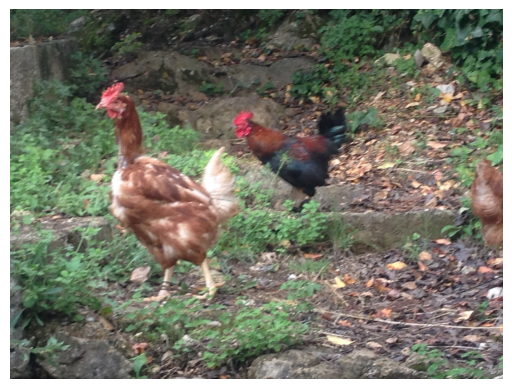

In [6]:
# plot sample image
img = plt.imread('../data/sample.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Inspect YOLO model

In [6]:
from ultralytics import YOLO
model = YOLO("../.data/yolov8n-cls.pt")
model.info()

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(99, 2719288, 0, 4.383948800000001)

In [7]:
results = model("../data/sample.jpg")


image 1/1 /Users/alex/Desktop/CS/ML/YADES/notebooks/../data/sample.jpg: 224x224 cock 0.53, hen 0.46, black_grouse 0.00, partridge 0.00, ruffed_grouse 0.00, 6.0ms
Speed: 13.4ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


In [18]:
detection = results[0]
print(f'{detection.names[detection.probs.top1]} - {detection.probs.top1conf:.2f}')

cock - 0.53


# Create Train-Val-Test Split in YOLO format

In [20]:
# extract and format in yolo format:
# YOLO_DATA_PATH/
#  |--- train/
#  |     |--- animal/
#  |     |--- non-animal/
#  |--- val/
#  |     |--- animal/
#  |     |--- non-animal/
#  |--- test/
#  |     |--- animal/
#  |     |--- non-animal/

os.makedirs(YOLO_DATA_PATH, exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'train', 'animal'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'train', 'non-animal'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'val', 'animal'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'val', 'non-animal'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'test', 'animal'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_PATH, 'test', 'non-animal'), exist_ok=True)

TRAIN_VAL_TEST_SPLIT = (0.8, 0.1, 0.1)

with zipfile.ZipFile(DATA_PATH_ZIP, 'r') as zip_ref:
    animals = [f for f in zip_ref.namelist() if 'Animals' in f]
    non_animals = [f for f in zip_ref.namelist() if 'Non-Animal' in f]

    for i, (f, label) in enumerate(zip(animals, ['animal'] * len(animals))):
        if i < len(animals) * TRAIN_VAL_TEST_SPLIT[0]:
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'train', label, f.split('/')[-1]))
        elif i < len(animals) * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]):
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'val', label, f.split('/')[-1]))
        else:
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'test', label, f.split('/')[-1]))

    for i, (f, label) in enumerate(zip(non_animals, ['non-animal'] * len(non_animals))):
        if i < len(non_animals) * TRAIN_VAL_TEST_SPLIT[0]:
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'train', label, f.split('/')[-1]))
        elif i < len(non_animals) * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]):
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'val', label, f.split('/')[-1]))
        else:
            extract_zipped_file(zip_ref, f, os.path.join(YOLO_DATA_PATH, 'test', label, f.split('/')[-1]))

In [2]:
# copy ../data/data.yaml to ../.data/animal/data.yaml
import shutil
shutil.copy('../data/data.yaml', '../.data/animal/data.yaml')

'../.data/animal/data.yaml'

## Inspect Counts of Classes

In [22]:
num_train_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'train', 'animal')))
num_train_non_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'train', 'non-animal')))
num_val_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'val', 'animal')))
num_val_non_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'val', 'non-animal')))
num_test_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'animal')))
num_test_non_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'non-animal')))

print(f'Train: {num_train_animals} animals, {num_train_non_animals} non-animals')
print(f'Val: {num_val_animals} animals, {num_val_non_animals} non-animals')
print(f'Test: {num_test_animals} animals, {num_test_non_animals} non-animals')

total_animals = num_train_animals + num_val_animals + num_test_animals
total_non_animals = num_train_non_animals + num_val_non_animals + num_test_non_animals

print(f'Total: {total_animals} animals, {total_non_animals} non-animals')

Train: 14486 animals, 12839 non-animals
Val: 1811 animals, 1605 non-animals
Test: 1810 animals, 1604 non-animals
Total: 18107 animals, 16048 non-animals


## Plot distribution of image aspect ratios

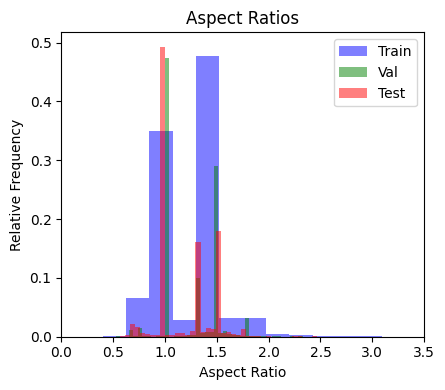

In [12]:
# plot distribution of aspect ratios
from PIL import Image
import numpy as np

def get_image_aspect_ratio(image_path):
    with Image.open(image_path) as img:
        return img.width / img.height
    
train_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'train', 'animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'train', 'animal'))]
train_non_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'train', 'non-animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'train', 'non-animal'))]
val_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'val', 'animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'val', 'animal'))]
val_non_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'val', 'non-animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'val', 'non-animal'))]
test_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'test', 'animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'animal'))]
test_non_animal_aspect_ratios = [get_image_aspect_ratio(os.path.join(YOLO_DATA_PATH, 'test', 'non-animal', f)) for f in os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'non-animal'))]

train_aspect_ratios = np.array(train_animal_aspect_ratios + train_non_animal_aspect_ratios)
val_aspect_ratios = np.array(val_animal_aspect_ratios + val_non_animal_aspect_ratios)
test_aspect_ratios = np.array(test_animal_aspect_ratios + test_non_animal_aspect_ratios)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(train_aspect_ratios, bins=50, color='blue', alpha=0.5, label='Train', weights=np.zeros_like(train_aspect_ratios) + 1. / train_aspect_ratios.size)
plt.hist(val_aspect_ratios, bins=50, color='green', alpha=0.5, label='Val', weights=np.zeros_like(val_aspect_ratios) + 1. / val_aspect_ratios.size)
plt.hist(test_aspect_ratios, bins=50, color='red', alpha=0.5, label='Test', weights=np.zeros_like(test_aspect_ratios) + 1. / test_aspect_ratios.size)
plt.title('Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Relative Frequency')
plt.legend()
plt.xlim(0, 3.5)

plt.tight_layout()
plt.show()